# AML — Task 1
## Predict the age of a brain from MRI features
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from pandas_profiling import ProfileReport

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor
from sklearn.neighbors import LocalOutlierFactor

---
## Function definition

---
### Load datasets

In [3]:
def load_raw_data():
    X_train = pd.read_csv('data/X_train.csv').drop(columns=['id'])
    y_train = pd.read_csv('data/y_train.csv').drop(columns=['id'])
    X_test = pd.read_csv('data/X_test.csv').drop(columns=['id'])
    return X_train, y_train, X_test

---
### Export datasets

In [4]:
def export_to_csv(X_train_cleaned, y_train_cleaned, X_test_cleaned):
    X_train_cleaned.to_csv('data/X_train_cleaned.csv', index=False)
    y_train_cleaned.to_csv('data/y_train_cleaned.csv', index=False)
    X_test_cleaned.to_csv('data/X_test_cleaned.csv', index=False)

---
### Outlier detection

In [5]:
def remove_outliers(X_train, y_train, contamination='auto', verbose=1):
    """
    Remove the ouliers from our dataset. Temporarily replace the nan values by 
    the median to perform the outlier detection.

    Parameters
    ----------
    X_train : pd.df
        The features (what we will use to see the outliers)
    y_train : pd.df
        The labels
    contamination : int, optional
        The percent of outliers found by the isolation forest if it is used.

    Return
    ------
    (pd.df, pd.df)
        The data with the outliers rows removed
    """
    # Save a mask of the imputed values to be able to redo the imputation once the outlier detection is done
    X_train_null_mask = X_train.isna()
    
    # Need to impute nan values for the outlier detection to work (cannot deal with nan)
    X_train_imputed = pd.DataFrame(SimpleImputer(strategy="median", verbose=verbose).fit_transform(X_train))
    
#     clf = IsolationForest(contamination=contamination, random_state=0) # modify here
    clf = LocalOutlierFactor(contamination=contamination) # modify here
    outliers_mask = pd.Series(clf.fit_predict(X_train_imputed))
    
    if verbose:
        print(f"Detected {(outliers_mask == -1).sum()} outliers, out of {outliers_mask.shape[0]} samples ({100 * (outliers_mask == -1).sum() / outliers_mask.shape[0]:.2f}%).")
    
    # Put back the nan values
    # convert the null mask to np.array so it is correctly applied since X_train indexes have changed
    X_train_no_outliers = X_train_imputed.mask(np.array(X_train_null_mask))
    
    # Remove outliers from the training set
    X_train_no_outliers = X_train_no_outliers.loc[outliers_mask == 1, :]
    y_train_no_outliers = y_train.loc[outliers_mask == 1, :]
    
    return (X_train_no_outliers, y_train_no_outliers)

---
### Data scaling
Should be done as soon as possible because can have an effect (e.g. on distances for `KNNImputer`)

In [6]:
def scale(X_train, X_test):
    # Do the scaling, saving the scaler to use it for X_test too. No need for imputation, just ignore nan values.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train))
    # Cast X_test to np.array to avoid warning of model trained without feature names but X having some.
    X_test_scaled = pd.DataFrame(scaler.transform(np.array(X_test)))
    return (X_train_scaled, X_test_scaled)

---
### Imputation of values

In [59]:
def impute_values(X_train, X_test, method='knn'):
    print(f"For the train dataset, there are {np.array(X_train.isna()).sum().sum()} nan values, out of {X_train.shape[0]*X_train.shape[1]} ({100*np.array(X_train.isna()).sum().sum()/(X_train.shape[0]*X_train.shape[1]):.2f}%).")
    
    imputer = None
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=6, weights='uniform').fit(X_train)
    elif method == 'iterative':
        # Runs VERY slowly
        imputer = IterativeImputer(random_state=0, max_iter=15, verbose=2).fit(X_train)
    
    X_train_imputed = pd.DataFrame(imputer.transform(X_train))
    X_test_imputed = pd.DataFrame(imputer.transform(X_test))
    return (X_train_imputed, X_test_imputed)

---
### Feature selection

In [8]:
def select_features(X_train, y_train, X_test):
    X_train_selected_features, X_test_selected_features = remove_constant_features(X_train, X_test)
    X_train_selected_features, X_test_selected_features = remove_too_correlated_features(X_train_selected_features, X_test_selected_features)
    X_train_selected_features, X_test_selected_features = remove_random_features(X_train_selected_features, y_train, X_test_selected_features, percentile=80)
    
    return X_train_selected_features, X_test_selected_features

In [9]:
def remove_constant_features(X_train, X_test, verbose=1):
    X_train_selected_features = X_train.loc[:, (X_train != X_train.iloc[0]).any()]
    X_test_selected_features = X_test.loc[:, (X_train != X_train.iloc[0]).any()]
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of constant values ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%).")
    
    return X_train_selected_features, X_test_selected_features

In [10]:
def remove_too_correlated_features(X_train, X_test, threshold=0.7, verbose=1):
    X_train_corr_ = X_train.corr()

    X_train_too_correlated = (X_train_corr_.mask(
        np.tril(np.ones([len(X_train_corr_)]*2, dtype=bool))).abs() > threshold).any()
    
    X_train_selected_features = X_train.loc[:, (~X_train_too_correlated)]
    X_test_selected_features = X_test.loc[:, (~X_train_too_correlated)]
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of correlation with another feature > {threshold} ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%).")

    return X_train_selected_features, X_test_selected_features

In [11]:
def remove_random_features(X_train, y_train, X_test, Xtrm, Xtem, percentile=80, verbose=1):
    selector = SelectPercentile(f_regression, percentile=percentile) # modify here
    selector.fit(X_train, np.array(y_train).ravel())
    X_train_selected_features = pd.DataFrame(selector.transform(X_train))
    X_test_selected_features = pd.DataFrame(selector.transform(X_test))
    Xtrm_selected_features = pd.DataFrame(selector.transform(Xtrm))
    Xtem_selected_features = pd.DataFrame(selector.transform(Xtem))
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of low correlation with target ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%).")
        
    return X_train_selected_features, X_test_selected_features, Xtrm_selected_features, Xtem_selected_features

---
### Models

In [12]:
def best_lasso(X_train, y_train):
    lasso = Lasso(max_iter=100000)
    gs_lasso_params = {
        'alpha': np.logspace(-2, 0, 20),
    }
    gs_lasso = GridSearchCV(lasso, gs_lasso_params, cv=5, verbose=3)
    gs_lasso.fit(X_train, y_train)
    
    print(f"The best validation score obtained is {gs_lasso.best_score_:.5f} with\n\talpha: {gs_lasso.best_params_['alpha']}")
    
    return gs_lasso

In [13]:
def best_svr(X_train, y_train):
    svr = SVR()
    gs_svr_params = {
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'C': np.logspace(-1, 2.2, 4),
        'epsilon': np.logspace(-2, 1, 3),
    }
    gs_svr = GridSearchCV(svr, gs_svr_params, cv=5, verbose=3)
    gs_svr.fit(X_train, y_train)
    
    print(f"""The best validation score obtained is {gs_svr.best_score_:.5f} with
    \tkernel: {gs_svr.best_params_['kernel']}
    \tC: {gs_svr.best_params_['C']}
    \tepsilon: {gs_svr.best_params_['epsilon']}""")
    
    return gs_svr

In [48]:
def best_gbr(X_train, y_train):
#     gbr = GradientBoostingRegressor(random_state=0)
#     gs_gbr_params = {
#         "learning_rate": np.logspace(-3, -1, 3),
#         "n_estimators": np.logspace(1, 3, 3),
#         "subsample": [0.7, 1],
#         "max_depth": [3, 4, 5],
#     }
#     gs_gbr = GridSearchCV(gbr, gs_gbr_params, cv=5, verbose=3, error_score='raise')
#     gs_gbr.fit(X_train, y_train)
#     return gs_gbr

    params = {
        "loss": "squared_error",
        "n_estimators": 250,
        "learning_rate": 0.025,
        "subsample": 0.75,
        "max_depth": 6,
        "min_samples_split": 5,
        "n_iter_no_change": 100,
        "validation_fraction": 0.1,
        "random_state": 0, 
        "verbose": 1,
    }

    gbr = GradientBoostingRegressor(**params)
    
    # Get the validation score
    gbr_cv_scores = cross_val_score(gbr, X_train, y_train, n_jobs=-1, verbose=3)
    print(f"""Validation score obtained is {np.mean(gbr_cv_scores):.4f} with
    \t{params}""")
    
    # Fit model (because previous function does not return fitted model)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    gbr.fit(X_train, y_train)
    
    test_score = np.zeros(gbr.n_estimators_, dtype=np.float64)
    for i, y_pred in enumerate(gbr.staged_predict(X_test)):
        test_score[i] = gbr.loss_(y_test, y_pred)

    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title("Deviance")
    plt.plot(
        np.arange(gbr.n_estimators_),
        gbr.train_score_,
        "b-",
        label="Training Set Deviance",
    )
    plt.plot(
        np.arange(gbr.n_estimators_), test_score, "r-", label="Test Set Deviance"
    )
    plt.legend(loc="upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Deviance")
    fig.tight_layout()
    plt.show()
    
    return gbr

---
### Submission file

In [15]:
def create_submission(prediction, sub_id, basepath='submissions/task1-sub'):
    result = prediction.copy()
    result = result.rename(columns={0: 'y'})
    result['id'] = range(0, len(result))
    result = result[['id', 'y']]
    result.to_csv(basepath + str(sub_id) + '.csv', index=False)

---
## Run pipeline

---
### Data preprocessing

In [16]:
# print("Loading raw data...")
# X_train, y_train, X_test = load_raw_data()

# print("Removing outliers...")
# X_train_no_outliers, y_train_no_outliers = remove_outliers(X_train, y_train)

# print("Scaling data...")
# X_train_scaled, X_test_scaled = scale(X_train_no_outliers, X_test)

# print("Imputing nan values...")
# X_train_imputed, X_test_imputed = impute_values(X_train_scaled, X_test_scaled, method=knn')

# print("Selecting features...")
# X_train_selected_features, X_test_selected_features = select_features(X_train_imputed, y_train_no_outliers, X_test_imputed)

# print("Exporting clean data to csv...")
# X_train_cleaned, y_train_cleaned, X_test_cleaned = X_train_selected_features, y_train_no_outliers, X_test_selected_features
# export_to_csv(X_train_cleaned, y_train_cleaned, X_test_cleaned)

# print("All done!")

In [65]:
print("Loading raw data...")
X_train, y_train, X_test = load_raw_data()

print("Removing outliers...")
X_train, y_train = remove_outliers(X_train, y_train)

print("Scaling data...")
X_train, X_test = scale(X_train, X_test)

print("Selecting features...")
X_train, X_test = remove_constant_features(X_train, X_test)
X_train, X_test = remove_too_correlated_features(X_train, X_test)

#TODO: Clean pipeline
# If we want iterative imputation, and don't want to run it for one hour (should try at one point though), need to
# do feature selection before we do imputation. Except biggest filter for feature selection is f_regression which
# cannot deal with nan values. Therefore, intermediary dumb knn imputation was quickly/dirtily 
# implemented to see results.
# Conclusion: we achieve ~same or better validation scores with a LOT less features, seems like an 
# interresting way forward (even though test scores are a bit lower once submitted, but to not 
# overfit on the public ones and fail on the secret ones, should only watch validation score)
X_train_mask = X_train.isna()
X_test_mask = X_test.isna()
X_train, X_test = impute_values(X_train, X_test, method='knn')
X_train, X_test, X_train_mask, X_test_mask = remove_random_features(X_train, y_train, X_test, X_train_mask, X_test_mask, percentile=20)
X_train = X_train.mask(np.array(X_train_mask))
X_test = X_test.mask(np.array(X_test_mask))

print("Imputing nan values...")
X_train, X_test = impute_values(X_train, X_test, method='iterative')

print("Exporting clean data to csv...")
export_to_csv(X_train, y_train, X_test)

print("All done!")

Loading raw data...
Removing outliers...
Detected 50 outliers, out of 1212 samples (4.13%).
Scaling data...
Selecting features...
0 features removed because of constant values (0.00%)
146 features removed because of correlation > 0.7 (17.55%)
For the train dataset, there are 60781 nan values, out of 797132 (7.62%).


/Users/antoine/miniconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


549 features removed because of low correlation with target (80.03%)
Imputing nan values...
For the train dataset, there are 12065 nan values, out of 159194 (7.58%).
[IterativeImputer] Completing matrix with shape (1162, 137)
[IterativeImputer] Ending imputation round 1/15, elapsed time 1.89
[IterativeImputer] Change: 23.347691166114693, scaled tolerance: 0.013896992902987433 
[IterativeImputer] Ending imputation round 2/15, elapsed time 3.82
[IterativeImputer] Change: 2.0044169947193318, scaled tolerance: 0.013896992902987433 
[IterativeImputer] Ending imputation round 3/15, elapsed time 5.95
[IterativeImputer] Change: 0.3507866998585426, scaled tolerance: 0.013896992902987433 
[IterativeImputer] Ending imputation round 4/15, elapsed time 8.33
[IterativeImputer] Change: 0.1477798955071734, scaled tolerance: 0.013896992902987433 
[IterativeImputer] Ending imputation round 5/15, elapsed time 10.45
[IterativeImputer] Change: 0.08213196633380365, scaled tolerance: 0.013896992902987433 
[I

---
### Model training

In [66]:
lasso = best_lasso(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........................alpha=0.01;, score=0.452 total time=   0.0s
[CV 2/5] END ........................alpha=0.01;, score=0.436 total time=   0.0s
[CV 3/5] END ........................alpha=0.01;, score=0.428 total time=   0.0s
[CV 4/5] END ........................alpha=0.01;, score=0.498 total time=   0.0s
[CV 5/5] END ........................alpha=0.01;, score=0.385 total time=   0.0s
[CV 1/5] END ........alpha=0.012742749857031334;, score=0.454 total time=   0.0s
[CV 2/5] END ........alpha=0.012742749857031334;, score=0.438 total time=   0.0s
[CV 3/5] END ........alpha=0.012742749857031334;, score=0.429 total time=   0.0s
[CV 4/5] END ........alpha=0.012742749857031334;, score=0.500 total time=   0.0s
[CV 5/5] END ........alpha=0.012742749857031334;, score=0.386 total time=   0.0s
[CV 1/5] END ........alpha=0.016237767391887217;, score=0.456 total time=   0.0s
[CV 2/5] END ........alpha=0.016237767391887217

In [67]:
svr = best_svr(X_train, np.array(y_train).ravel())

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ..C=0.1, epsilon=0.01, kernel=poly;, score=0.084 total time=   0.1s
[CV 2/5] END ..C=0.1, epsilon=0.01, kernel=poly;, score=0.054 total time=   0.1s
[CV 3/5] END ..C=0.1, epsilon=0.01, kernel=poly;, score=0.045 total time=   0.1s
[CV 4/5] END ..C=0.1, epsilon=0.01, kernel=poly;, score=0.051 total time=   0.1s
[CV 5/5] END ..C=0.1, epsilon=0.01, kernel=poly;, score=0.021 total time=   0.1s
[CV 1/5] END ...C=0.1, epsilon=0.01, kernel=rbf;, score=0.131 total time=   0.1s
[CV 2/5] END ...C=0.1, epsilon=0.01, kernel=rbf;, score=0.106 total time=   0.1s
[CV 3/5] END ...C=0.1, epsilon=0.01, kernel=rbf;, score=0.104 total time=   0.3s
[CV 4/5] END ...C=0.1, epsilon=0.01, kernel=rbf;, score=0.118 total time=   0.1s
[CV 5/5] END ...C=0.1, epsilon=0.01, kernel=rbf;, score=0.112 total time=   0.1s
[CV 1/5] END C=0.1, epsilon=0.01, kernel=sigmoid;, score=0.323 total time=   0.1s
[CV 2/5] END C=0.1, epsilon=0.01, kernel=sigmo

[CV 4/5] END C=1.1659144011798317, epsilon=10.0, kernel=sigmoid;, score=0.365 total time=   0.0s
[CV 5/5] END C=1.1659144011798317, epsilon=10.0, kernel=sigmoid;, score=0.312 total time=   0.0s
[CV 1/5] END C=13.593563908785255, epsilon=0.01, kernel=poly;, score=0.482 total time=   0.1s
[CV 2/5] END C=13.593563908785255, epsilon=0.01, kernel=poly;, score=0.363 total time=   0.1s
[CV 3/5] END C=13.593563908785255, epsilon=0.01, kernel=poly;, score=0.406 total time=   0.1s
[CV 4/5] END C=13.593563908785255, epsilon=0.01, kernel=poly;, score=0.386 total time=   0.2s
[CV 5/5] END C=13.593563908785255, epsilon=0.01, kernel=poly;, score=0.368 total time=   0.1s
[CV 1/5] END C=13.593563908785255, epsilon=0.01, kernel=rbf;, score=0.612 total time=   0.2s
[CV 2/5] END C=13.593563908785255, epsilon=0.01, kernel=rbf;, score=0.517 total time=   0.2s
[CV 3/5] END C=13.593563908785255, epsilon=0.01, kernel=rbf;, score=0.508 total time=   0.2s
[CV 4/5] END C=13.593563908785255, epsilon=0.01, kernel=r

[CV 2/5] END C=158.48931924611142, epsilon=10.0, kernel=rbf;, score=0.377 total time=   0.0s
[CV 3/5] END C=158.48931924611142, epsilon=10.0, kernel=rbf;, score=0.440 total time=   0.0s
[CV 4/5] END C=158.48931924611142, epsilon=10.0, kernel=rbf;, score=0.391 total time=   0.0s
[CV 5/5] END C=158.48931924611142, epsilon=10.0, kernel=rbf;, score=0.456 total time=   0.0s
[CV 1/5] END C=158.48931924611142, epsilon=10.0, kernel=sigmoid;, score=-7529.159 total time=   0.1s
[CV 2/5] END C=158.48931924611142, epsilon=10.0, kernel=sigmoid;, score=-5314.672 total time=   0.2s
[CV 3/5] END C=158.48931924611142, epsilon=10.0, kernel=sigmoid;, score=-4091.563 total time=   0.1s
[CV 4/5] END C=158.48931924611142, epsilon=10.0, kernel=sigmoid;, score=-3055.399 total time=   0.1s
[CV 5/5] END C=158.48931924611142, epsilon=10.0, kernel=sigmoid;, score=-4950.710 total time=   0.1s
The best validation score obtained is 0.55284 with
    	kernel: rbf
    	C: 13.593563908785255
    	epsilon: 0.316227766016

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.9s remaining:   19.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


Validation score obtained is 0.5904 with
    	{'loss': 'squared_error', 'n_estimators': 250, 'learning_rate': 0.025, 'subsample': 0.75, 'max_depth': 6, 'min_samples_split': 5, 'n_iter_no_change': 100, 'validation_fraction': 0.1, 'random_state': 0, 'verbose': 1}
      Iter       Train Loss      OOB Improve   Remaining Time 
         1          91.3713           2.7151            8.69s
         2          90.4951           2.4329            8.24s
         3          87.5395           1.8259            8.23s
         4          84.9354           1.7079            8.17s
         5          81.1857           1.5119            8.14s
         6          77.7074           1.7922            8.21s
         7          78.0268           1.6303            8.35s
         8          73.7842           1.7695           10.68s
         9          72.9198           1.3300           10.44s
        10          69.6703           1.6567           10.24s
        20          49.8719           0.7727           

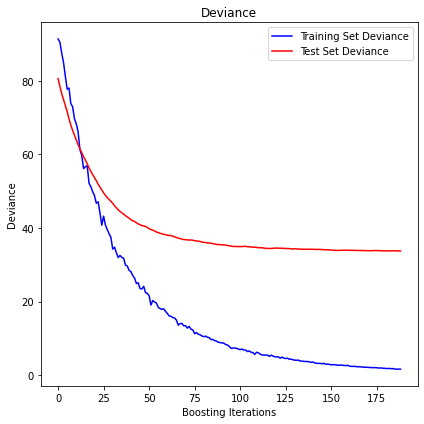

In [68]:
#TODO: could not manage to get grid search to work with this, should look into it as there are a lot of
# hyperparameters at play
gbr = best_gbr(X_train, np.array(y_train).ravel())

---
### Creation of the submission file

In [69]:
prediction = pd.DataFrame(gbr.predict(X_test)) # modify here
sub_id = 13 # modify here
create_submission(prediction, sub_id)

Link where to submit: https://aml.ise.inf.ethz.ch/task1/#submission